In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
pip install torch torchvision matplotlib numpy opencv-python


In [37]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 93.5MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [51]:
def process_image(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tensor_image = F.to_tensor(image)
    return image, tensor_image


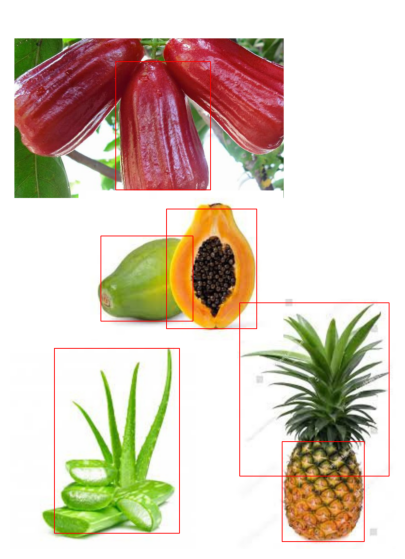

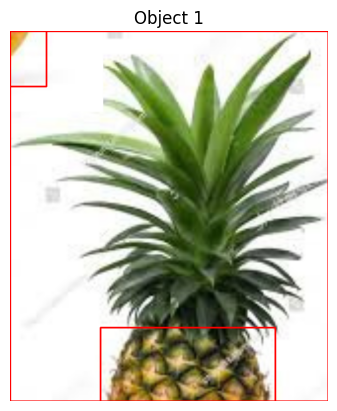

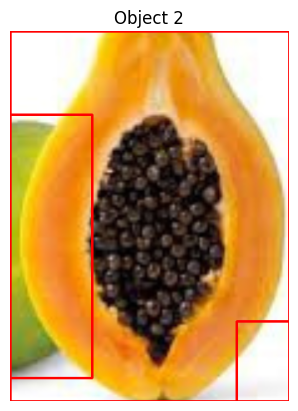

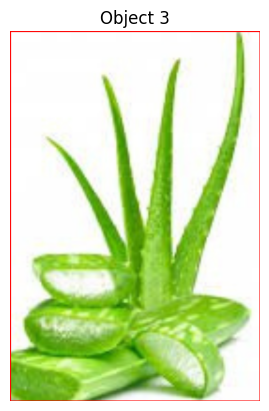

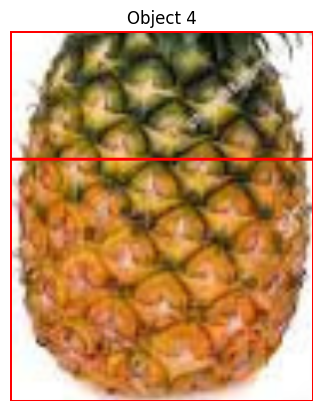

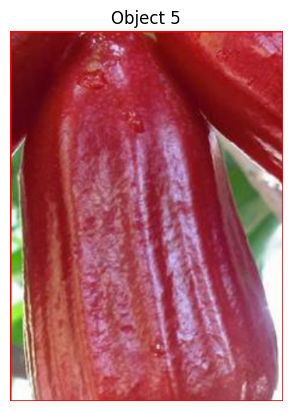

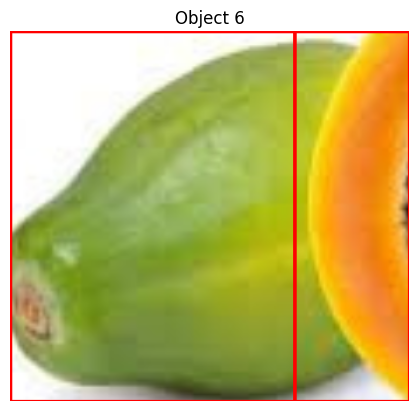

In [54]:
# Load the pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

def process_image(image_path):
    """
    Load and preprocess the image for the Mask R-CNN model.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tensor_image = F.to_tensor(image).unsqueeze(0)  # Convert to tensor and add batch dimension
    return image, tensor_image

def non_maximum_suppression(boxes, scores, threshold=0.3):
    """
    Apply Non-Maximum Suppression (NMS) to filter overlapping boxes.
    """
    keep = torch.ops.torchvision.nms(boxes, scores, threshold)
    return keep

def visualize_and_extract_objects(image, predictions, threshold=0.3, max_objects=10):
    """
    Visualize bounding boxes and extract separate images for detected objects.
    """
    boxes = predictions["boxes"]
    scores = predictions["scores"]
    extracted_objects = []

    # Apply Non-Maximum Suppression (NMS)
    keep_indices = non_maximum_suppression(boxes, scores, threshold)
    sorted_indices = keep_indices[:max_objects]  # Limit to top N objects

    for idx in sorted_indices:
        if scores[idx] > threshold:
            # Extract bounding box
            x1, y1, x2, y2 = boxes[idx].detach().numpy().astype(np.int32)

            # Draw bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red bounding box

            # Extract and save the object as a separate image
            cropped_object = image[y1:y2, x1:x2]
            extracted_objects.append(cropped_object)

    return image, extracted_objects

# Process and predict on the uploaded image
uploaded_image_path = "/content/drive/MyDrive/Dataset/archive/composite images/canva 1.png"
original_image, tensor_image = process_image(uploaded_image_path)

# Run predictions
with torch.no_grad():
    predictions = model(tensor_image)[0]

# Visualize and extract objects
result_image, extracted_objects = visualize_and_extract_objects(
    original_image.copy(), predictions, threshold=0.2, max_objects=10
)

# Display the final image with bounding boxes
plt.figure(figsize=(10, 7))
plt.imshow(result_image)
plt.axis('off')
plt.show()

# Save and display individual extracted objects
for i, obj in enumerate(extracted_objects):
    obj_path = f"/mnt/data/object_{i+1}.png"
    cv2.imwrite(obj_path, cv2.cvtColor(obj, cv2.COLOR_RGB2BGR))
    plt.figure()
    plt.title(f"Object {i+1}")
    plt.imshow(obj)
    plt.axis('off')
    plt.show()